In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import os

from scale.plot import plot_confusion_matrix, plot_embedding, plot_heatmap
from scale.utils import read_labels, reassign_cluster_with_ref
from scale.specifity import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
input_dir = '../data/Breast_Tumor/' ## containing data.txt and labels.txt
out_dir = '../result/Breast_Tumor/' ## all running results saved in the out_dir

In [3]:
raw = pd.read_csv(input_dir+'data.txt', sep='\t', index_col=0)
ref, classes, le = read_labels(input_dir+'labels.txt', return_enc=True)
y = le.inverse_transform(ref)

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 1. Feature embedding
different color representing ground truth cell types

In [4]:
os.makedirs('tsne', exist_ok=True)

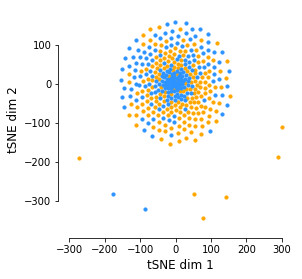

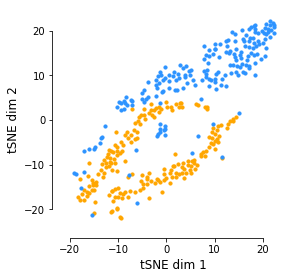

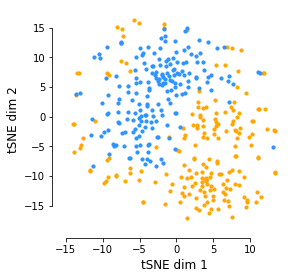

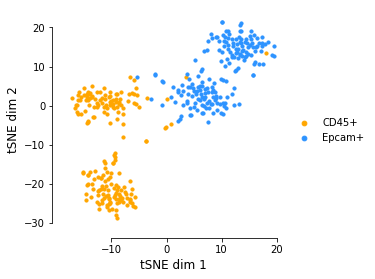

In [7]:
feature = pd.read_csv(out_dir+'feature.txt', sep='\t', index_col=0, header=None)
scVI_feature = pd.read_csv(out_dir+'scVI_latent.txt', sep='\t', index_col=0, header=None)
pca_feature = PCA(n_components=10, random_state=124).fit_transform(raw.T)

cmap = ['#FFA600','#2D93FF']
raw_emb = plot_embedding(raw.T, y, classes, cmap=cmap, show_legend=False, return_emb=True, 
               save_emb='tsne/raw_emb.txt', save='tsne/raw_emb.pdf')

pca_emb = plot_embedding(pca_feature, y, classes, cmap=cmap, show_legend=False, return_emb=True,
               save_emb='tsne/pca_emb.txt', save='tsne/pca_emb.pdf')

scvi_emb = plot_embedding(scVI_feature, y, classes, cmap=cmap, show_legend=False, return_emb=True,
               save_emb='tsne/scvi_emb.txt', save='tsne/scvi_emb.pdf')

scale_emb = plot_embedding(feature, y, classes, cmap=cmap, show_legend=True, return_emb=True,
               save_emb='tsne/scale_emb.txt', save='tsne/scale_emb.pdf')

## 2. Confusion matrix 
cluster assignments compared with ground truth

In [29]:
os.makedirs('confusion_matrix', exist_ok=True)

In [28]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, f1_score

Method: scABC  ARI score: 0.626  NMI score: 0.518 F1 score: 0.896


/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


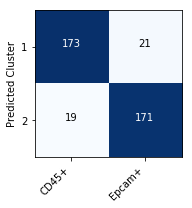

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Method: SC3  ARI score: 0.000  NMI score: 0.002 F1 score: 0.526


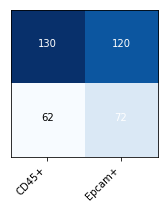

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Method: scVI  ARI score: 0.765  NMI score: 0.678 F1 score: 0.938


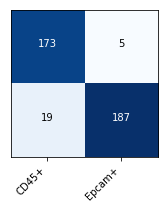

/home/xionglei/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Method: SCALE  ARI score: 0.918  NMI score: 0.863 F1 score: 0.979


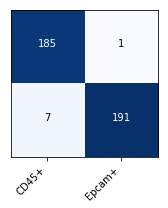

In [30]:
scABC_pred, _ = read_labels(out_dir+'scABC_predict.txt')
SC3_pred, _ = read_labels(out_dir+'SC3_predict.txt')
scVI_pred, _ = read_labels(out_dir+'scVI_predict.txt')
scale_pred, pred_classes = read_labels(out_dir+'cluster_assignments.txt')

show_yticks = True
methods = ['scABC', 'SC3', 'scVI', 'SCALE']
for pred, method in zip([scABC_pred, SC3_pred, scVI_pred, scale_pred], methods):
    pred = reassign_cluster_with_ref(pred, ref)
    ari = adjusted_rand_score(ref, pred)
    nmi = normalized_mutual_info_score(ref, pred)
    f1 = f1_score(ref, pred, average='micro')

    pred = le.inverse_transform(pred)
    cm = confusion_matrix(pred, y, labels=classes)
    
    print("Method: {}  ARI score: {:.3f}  NMI score: {:.3f} F1 score: {:.3f}".format(method, ari, nmi, f1))

    plot_confusion_matrix(cm, classes, pred_classes+1, title='', normalize=False, figsize=(3,3), show_cbar=False, 
                          show_xticks=True, show_yticks=show_yticks, save='confusion_matrix/'+method+'.pdf')   
    show_yticks = False

## 3. (Figure5) Batch effects and biological cell types captured are disentangled 

In [14]:
os.makedirs('Figure5', exist_ok=True)

### feature heatmap by plates

In [9]:
labels_plate = pd.read_csv(input_dir+'labels_plates.txt', sep='\t', index_col=0, header=None)[1].values

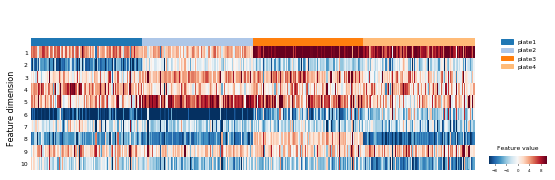

In [15]:
plot_heatmap(feature.T, labels_plate, vmin=-10, vmax=10, figsize=(10, 3), legend_font=6, cmap='RdBu_r', 
             bbox_to_anchor=(1.1, 1.1), position=(0.92, 0.15, .08, .04), ncol=1, 
             yticklabels=range(1, 11), row_cluster=False, ylabel='Feature dimension', cax_title='Feature value',
             save='Figure5/feature_heatmap_plate.pdf'
            )

In [17]:
legend_params = {'loc':'right', 'ncol':1, 'bbox_to_anchor':(1.0, 0.2), 'fontsize':8, 'markerscale':1.5}

### Full 

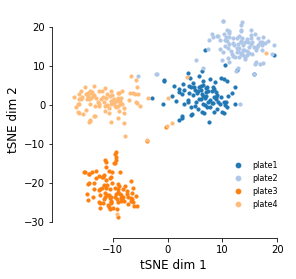

In [18]:
plot_embedding(feature, labels_plate, save_emb='Figure5/full_emb.pdf', **legend_params)

### Plate-related

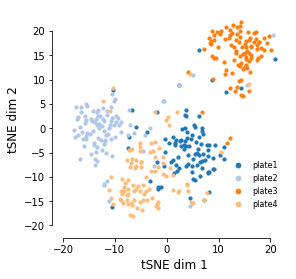

In [19]:
index = [1, 2, 3, 4, 7, 9]
plot_embedding(feature.iloc[:, index], labels_plate, 
               save_emb='Figure5/plate_related_emb.pdf', **legend_params)

### Plate-independent

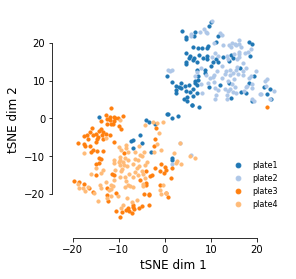

In [20]:
index = [0, 5, 6, 8]
emb = plot_embedding(feature.iloc[:, index], labels_plate, 
                     save_emb='Figure5/plate_independent_emb.pdf', **legend_params)

## 4. Chromvar results similar to original paper

In [21]:
dev = pd.read_csv(out_dir +'cisBP_dev.txt', index_col=0, sep='\t').fillna(0)
var = pd.read_csv(out_dir+'cisBP_var.txt', index_col=0, sep='\t')

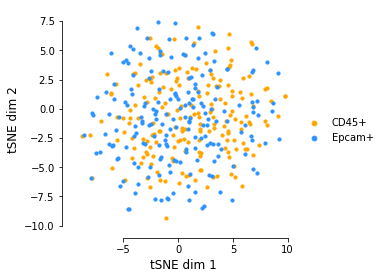

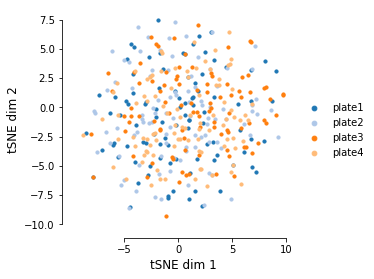

In [24]:
plot_embedding(dev.T, y, cmap=['#FFA600','#2D93FF'])
plot_embedding(dev.T, labels_plate)

## 5. Cell type specific peaks

In [25]:
from scale.specifity import cluster_specific, mat_specificity_score

In [34]:
scale_pred_ = reassign_cluster_with_ref(scale_pred, ref)
y_pred = np.array(['cluster'+str(i+1) for i in scale_pred_])

imputed = pd.read_csv(out_dir+'imputed_data.txt', sep='\t', index_col=0)

In [36]:
score_mat = mat_specificity_score(imputed, scale_pred)

n_top=1000
peak_index, peak_labels = cluster_specific(score_mat, top=n_top);print(len(peak_index))

2000


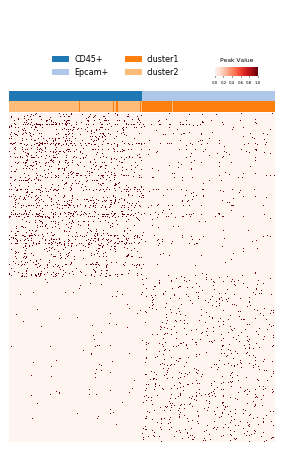

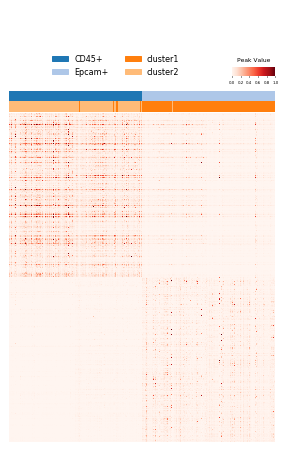

In [40]:
y_pred = np.array(['cluster'+str(i+1) for i in scale_pred])

plot_heatmap(raw.iloc[peak_index], y, y_pred=y_pred, row_labels=None, 
             ncol=2,cmap='Reds', vmax=1, row_cluster=False, legend_font=8, cax_title='Peak Value',
             figsize=(6, 8), bbox_to_anchor=(0.4, 1.2), position=(0.76, 0.76, 0.1, 0.015))

plot_heatmap(imputed.iloc[peak_index], y, y_pred=y_pred, row_labels=None, 
             ncol=2,cmap='Reds', vmax=1, row_cluster=False, legend_font=8, cax_title='Peak Value',
             figsize=(6, 8), bbox_to_anchor=(0.4, 1.2), position=(0.8, 0.76, 0.1, 0.015))